# Tomography tutorial notebook
This tutorial shows a complete procedure of a Pauli-Noise-Tomography with a sparse Pauli noise model. As this tutorial covers more the "how", than the "why", it is recommended to first read the accompanying pdf.

In detail, this tutorial will show the complete procedure:

0. Initializing the environment and choosing a noise model
1. Determining the measurement bases
2. Calculating the Pauli terms
3. Building the M-Matrices
4. Create the twirled Circuits for measurement, for all circuit depths
5. Preparing for measurement results
6. Processing measurement results
7. Determining the noise model coefficients

Whenever possible, refrences as to where in the main program in "pauli_lindblad_per" is performed, are added

### Disclaimer:
The language used here is qiskit, which has the little quirk, that paulis are written **backwards**.
A Pauli IXZ here means that qubit 0 has the Pauli Z, qubit 1 the Pauli X, and qubit 2 the Pauli I!

In [57]:
#Here all the needed imports are done. Nothing more
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import Pauli, pauli_basis
from qiskit_aer.noise import NoiseModel, pauli_error
from itertools import product, permutations, cycle
from random import random, choices
from qiskit import QuantumCircuit, transpile
import numpy as np
from scipy.optimize import curve_fit, nnls
from matplotlib import pyplot as plt

## Initializing the Environment and Selecting a Noise Model

Prior to execution, the backend must be established. If a real backend should be used, it would be implemented at this point instead. 
Here, the flexible virtual backend "GenericBackendV2" is utilized, allowing for the customization of the total qubit count and the topography in the form of a coupling map. For this tutorial, a 2-qubit backend with a linear topography is chosen. Experimentation with various parameters within this notebook is encouraged to gain a deeper understanding.

In [58]:
#The number of qubits in our system is set
num_qubits = 2
#With that number a coupling map is created. It can be choosen to be whatever desired. 
#Right now is does a linear coupling map with connections forwards [0,1](first bracket) and backwards [1,0](last bracket). 
#The implementation of the linear coupling here is flexable to work with any qubit count
coupling_map = [[i,i+1] for i in range(num_qubits-1)]+[[i+1,i] for i in range(num_qubits-1)] 
#This is then used to create the backend
backend = GenericBackendV2(num_qubits=num_qubits, coupling_map=coupling_map)

Here, the layer of the circuit to be tomographed is set. In the main program, this is automatically determined based on the entered circuit in "pauli_lindblad_per/framework/percircuit _circuit_to_benchmark_layers". However, in this context, it is set manually.

By default, a 2-qubit circuit with the CX gate on qubits 0 and 1 is used. This configuration can be altered as desired, but it should be keeped in mind, that there can only ever be one gate on any one qubit.

In [59]:
layer = QuantumCircuit(num_qubits)
layer.cx(0,1)
#layer.cx(2,3)
layer.draw()

q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘

The following block records which qubits are paired up by two-qubit-gates.

In [60]:
def get_index(qc, inst, i=None):
    if i != None:
        qubit = inst.qubits[i]
        index = -1
        for register in qc.qregs:  # Assuming you're using `QuantumCircuit`
            if qubit in register:
                index = register.index(qubit)
                break
        return index
    else:
        qubits = inst.qubits
        indexes = []
        for qubit in qubits:
            index = -1
            for register in qc.qregs:  # Assuming you're using `QuantumCircuit`
                if qubit in register:
                    index = register.index(qubit)
                    break
            indexes.append(index)
        return indexes

twoqubitpairs = []
for inst in layer:
	indexes = get_index(layer, inst)
	if len(indexes) == 2:
		twoqubitpairs.append(indexes)
print(twoqubitpairs)

[[0, 1]]


Since circuits are run on a simulated backend, the underlying noise model can be chosen. Noise models in Qiskit are applied at the backend.run(...) stage and must be prepared beforehand, by selecting the type of error and the relevant parameters. Here, a simple Pauli error noise model is created, where the Pauli errors and their occurrence probabilities are selected. The error is chosen to be very simple but can be made as complicated as desired. The error can be randomized for each run. Since only a CX gate is tomographed, single-qubit errors have no effect. However, if a single-qubit gate is to be tomographed, the single-qubit code at the bottom can be uncommented.

In [61]:
if True: # When set to 'True', a preset noisemodel will be choosen. When set to 'False', the noise model will be randomized on every run
	# The kind of Pauli error is choosen
	twoqubit_errorops = [Pauli('YX')] 
	# The respective chance for the Pauli errors is choosen. The two lists need to be equal in length
	twoqubit_errorprobs = [0.05] 

	# This is the same for single qubit gate errors
	singlequbit_errorops = [Pauli('X')] 
	singlequbit_errorprobs = [1]
else:
	# A random number of errors is choosen
	num = choices([3,4,5,6,7,8])[0]
	# Random Paulis are choosen. The random paulis can be duplicate and be the identity, so don't wonder when you get less the choosen number errors
	twoqubit_errorops = choices(pauli_basis(2), k=num)
	# Assign random probabilities
	twoqubit_errorprobs = [random()*.1/num for op in twoqubit_errorops] 

	# This is the same for single qubit gate errors
	num = choices([3,4,5,6,7,8])[0]
	singlequbit_errorops = choices(pauli_basis(1), k=num)
	singlequbit_errorprobs = [random()*.1/num for op in singlequbit_errorops]
# Create *normalized* error model.
twoqubit_error_template = [(op, p) for op,p in zip(twoqubit_errorops, twoqubit_errorprobs)]+[(Pauli("II"), 1-sum(twoqubit_errorprobs))]
twoqubit_error = pauli_error(twoqubit_error_template)
singlequbit_error_template = [(op, p) for op,p in zip(singlequbit_errorops, singlequbit_errorprobs)]+[(Pauli("I"), 1-sum(singlequbit_errorprobs))]
singlequbit_error = pauli_error(singlequbit_error_template)

noise_model = NoiseModel()
#add error model to two-qubit gates.
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])
#add error model to single-qubit gates. Comment the next line in if single qubit errors are wanted!
#noise_model.add_all_qubit_quantum_error(singlequbit_error, ['id','rz','sx'])

The next block calculated the true noise model for the full circuit to get the true coefficients. It only changing things if there are more than 2 qubits.

In [62]:
def mul_Pauli(pauli1, pauli2):
        result = pauli1.compose(pauli2)
        nophase = Pauli((result.z, result.x))
        return nophase

identity_string = 'I'*num_qubits
error_state = {Pauli(identity_string): 1}
for indexes in twoqubitpairs:
	temp_error_state = {}
	for (op, p) in twoqubit_error_template:
		temp_string = (identity_string[:indexes[0]] + "".join(reversed(str(op)))[0]+ identity_string[indexes[0]+1:])
		op = Pauli("".join(reversed(temp_string[:indexes[1]] + "".join(reversed(str(op)))[1]+ temp_string[indexes[1]+1:])))
		for og_op in error_state:
			og_p = error_state[og_op]
			new_op = mul_Pauli(op, og_op)
			temp_error_state[new_op] = temp_error_state.get(new_op, 0) + p*og_p
	error_state = temp_error_state
print(error_state)
error_state_template = [(op, error_state[op]) for op in error_state]
nqubit_error = pauli_error(error_state_template)

{Pauli('YX'): 0.05, Pauli('II'): 0.95}


## Determining the measurement bases

The following cell determines the nine Pauli bases used to make measurements simultaneously. It uses the coupling map from `backend` in conjuction with the procedure described in Figure S3 of the paper "Probabilistic error cancellation with sparse pauli-lindblad models on noisy quantum processors" by van den Berg. The output is an array of nine Pauli operators.

In the main code this happens is "pauli_lindblad_per/tomography/processorspec.py"

In [63]:
NUM_BASES = 9
        
bases = [['I']*num_qubits for i in range(NUM_BASES)]

#To accommodate a more complex backend topography, where single qubits can have three or more predecessors, the main code determines which qubits are actually utilized by the layer. 
#This list is then used as the variable in the subgraph function to exclude qubits as predecessors, in the hopes that it the limit of three predecessors is not exceeded that way.
#For a linear topography, it is safe to just pass all qubits
connectivity = backend.coupling_map.graph.subgraph([i for i in range(num_qubits)])

for vertex in range(num_qubits):
    #copied from Fig. S3 in van den Berg
    orderings = {"XXXYYYZZZ":"XYZXYZXYZ",
                        "XXXYYZZZY":"XYZXYZXYZ",
                        "XXYYYZZZX":"XYZXYZXYZ",
                        "XXZYYZXYZ":"XYZXZYZYX",
                        "XYZXYZXYZ":"XYZZXYYZX"}
    
    children = connectivity.neighbors(vertex)
    predecessors = [c for c in children if c < vertex]

    match len(predecessors):
        #trivial if no predecessors
        case 0:
            cycp = cycle("XYZ")
            for i,_ in enumerate(bases):
                bases[i][vertex] = next(cycp)
        #Choose p1:"XXXYYYZZZ" and p2:"XYZXYZXYZ" if one predecessor
        case 1:
            pred, = predecessors
            #store permutation of indices so that predecessor has X,X,X,Y,Y,Y,Z,Z,Z
            _,bases = list(zip(*sorted(zip([p[pred] for p in bases], bases))))
            cycp = cycle("XYZ")
            for i,_ in enumerate(bases):
                bases[i][vertex] = next(cycp)
        case 2:
            pred0,pred1 = predecessors
            _,bases = list(zip(*sorted(zip([p[pred0] for p in bases], bases))))
            #list out string with permuted values of predecessor 2
            substr = [p[pred0] for p in bases]
            #match predecessor two with a permutation of example_orderings
            reordering = ""
            for perm in permutations("XYZ"):
                substr = "".join(["XYZ"[perm.index(p)] for p in substr])
                if substr in orderings:
                    current = orderings[substr] 
                    for i,p in enumerate(current):
                        bases[i][vertex] = p
                    break
        case _: #processor needs to have connectivity so that there are <= 2 predecessors
            raise Exception("Three or more predecessors encountered")

bases = [Pauli("".join(string[::-1])) for string in bases] #Paulis in qiskit are written backwards, to the order of the bases has to be reversed
print("Pauli basis:", ["".join(b.to_label()) for b in bases])

Pauli basis: ['XX', 'YX', 'ZX', 'XY', 'YY', 'ZY', 'XZ', 'YZ', 'ZZ']


## Calculating the Pauli terms

In order to calculate the Pauli terms all the two and one weight paulis are crafted witht the the backend edge list.

This also happens in "pauli_lindblad_per/tomography/processorspec.py"

In [64]:
model_terms = set()
identity = ["I"]*num_qubits

trimmed_edge_list = [connection for connection in connectivity.edge_list()]
#get all weight-two Paulis on with support on neighboring qubits
for q1,q2 in trimmed_edge_list:
	for p1, p2 in product("IXYZ", repeat=2):
		pauli = identity.copy()
		pauli[q1] = p1
		pauli[q2] = p2
		model_terms.add("".join(reversed(pauli)))

node_indices = [indice for indice in connectivity.node_indices()]

#get all weight-one Paulis. This will only ever add paulis, if the topography includes isolated qubits
for q in node_indices: 
	for p in "IXYZ":
		pauli = identity.copy()
		pauli[q] = p 
		model_terms.add("".join(reversed(pauli)))

model_terms.remove("".join(identity))

model_terms = [Pauli(p) for p in sorted(model_terms)]
print("Model terms:", [m.to_label() for m in model_terms])

Model terms: ['IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']


For later comparison the ideal fidelities are calculated.

{Pauli('II'): np.complex128(1+0j), Pauli('IX'): np.complex128(1+0j), Pauli('IY'): np.complex128(0.8999999999999999+0j), Pauli('IZ'): np.complex128(0.8999999999999999+0j), Pauli('XI'): np.complex128(0.8999999999999999+0j), Pauli('XX'): np.complex128(0.8999999999999999+0j), Pauli('XY'): np.complex128(1+0j), Pauli('XZ'): np.complex128(1+0j), Pauli('YI'): np.complex128(1+0j), Pauli('YX'): np.complex128(1+0j), Pauli('YY'): np.complex128(0.8999999999999999+0j), Pauli('YZ'): np.complex128(0.8999999999999999+0j), Pauli('ZI'): np.complex128(0.8999999999999999+0j), Pauli('ZX'): np.complex128(0.8999999999999999+0j), Pauli('ZY'): np.complex128(1+0j), Pauli('ZZ'): np.complex128(1+0j)}


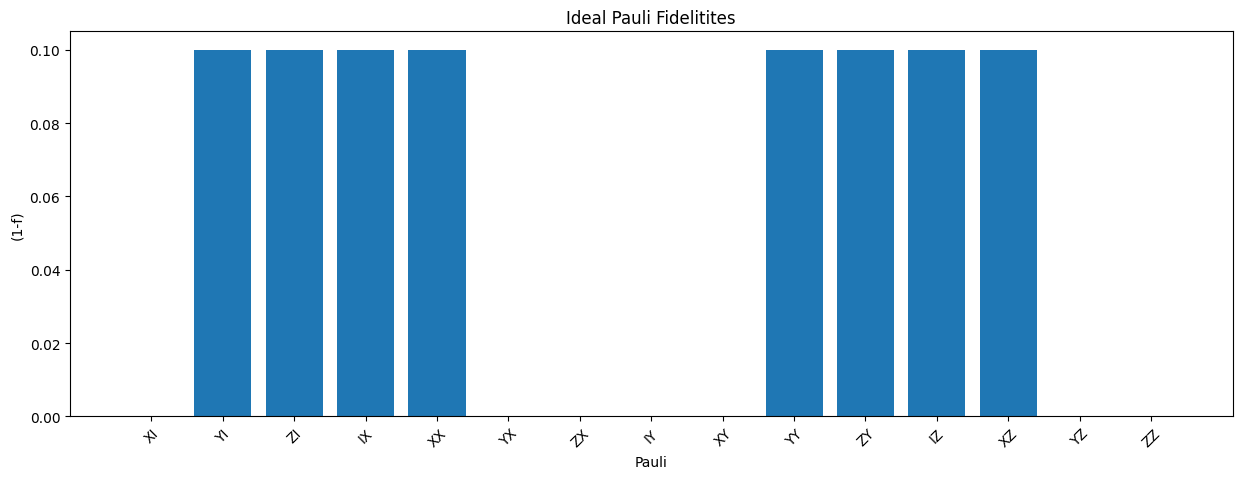

In [65]:
plt.figure(figsize=(15, 5))
from qiskit.quantum_info import Pauli, pauli_basis, SuperOp, PTM, Operator
real_errors = {}
transfer_matrix = PTM(nqubit_error.to_quantumchannel()).data
for i,pauli in enumerate(pauli_basis(num_qubits)):
    real_errors[pauli] = transfer_matrix[i][i]
for pauli in model_terms:
	#plt.bar(pauli.to_label(), (1-real_errors[pauli]).real, color="tab:blue")
	plt.bar("".join(reversed(pauli.to_label())), (1-real_errors[pauli]).real, color="tab:blue")

plt.title("Ideal Pauli Fidelitites")
plt.xlabel("Pauli")
plt.ylabel("(1-f)")
plt.xticks(rotation=45)

print(real_errors)

The simulator refuses to simulate Pauli instructions that include a global phase, even though there is no clear reason for this. The `nophase` method is used to remove the phase from an operator. The `conjugate` method returns the conjugation of an Pauli operator by the layer.

In [66]:
#remove the phase from a Pauli
def nophase(pauli):
    return Pauli((pauli.z, pauli.x))

def conjugate(pauli):
    return nophase(pauli.evolve(layer))

## Create the twirled Circuits for measurement, for all circuit depths
The following method performs the following function:
* Create new empty circuit
* Change basis of new circuit according to passed prep basis
* Repeat n-times, as per passed value:
	* Generate a random pauli, apply it to the circuit
	* Apply the layer gate
* Invert the pauli frame
* Change basis into the passed measurement basis.

The method takes as input the preparation and measurement bases (which can be different for the single measurements), the number of repetitions of the noisy layer

If the circuits are to be run on real hardware or more accuratly simulated backends, the transpile function should be commented it. The function changes the circuit, by breaking gates down into hardware native gate and optimizes the circuit. For the tutorial, this is not needed.

In [67]:
def instance( 
	prep_basis : Pauli, 
	meas_basis : Pauli, 
	noise_repetitions : int):

	circ = QuantumCircuit(num_qubits) #storing the final circuit

	#get preparation operators from desired basis 
	def prep(basis, qubit, qc):
		if basis.equiv(Pauli("X")):
			qc.h(qubit) 
		elif basis.equiv(Pauli("Y")):
			qc.h(qubit)
			qc.s(qubit)

	#apply operators to a quantum circuit to measure in desired pauli basis
	def meas(basis, qubit, qc):
		if basis.equiv(Pauli("X")):
			qc.h(qubit)
		elif basis.equiv(Pauli("Y")):
			qc.sdg(qubit)
			qc.h(qubit)


	pauli_frame = Pauli("I"*num_qubits)

	#apply the prep and twirling operators to the circuit
	for q,b in enumerate(prep_basis):
		prep(b,q,circ)

	circ.barrier()

	#apply repetitions of noise, including basis-change gates when needed
	for i in range(noise_repetitions):

		twirl = Pauli("".join(choices("IXYZ", k=num_qubits)))
		pauli_frame = pauli_frame.compose(twirl)
		pauli_frame = conjugate(pauli_frame)

		for i,p in enumerate(twirl):
			circ.append(p, [i])

		circ = circ.compose(layer)
		circ.barrier()

	#choose string of bit flips for readout twirling
	rostring = "".join(choices(['I','X'], k=num_qubits))
	for i,p in enumerate(pauli_frame):
		circ.append(p, [i])
	circ.barrier()
	for q,(b,r) in enumerate(zip(meas_basis, rostring)):
		meas(b, q, circ)
		if r == "X":
			circ.x(q)

	circ.measure_all()

	#circ = transpile(circuit, backend) # Comment this in, if run on real hardware

	circ.metadata = {
		"prep_basis":prep_basis,
			"meas_basis":meas_basis, 
			"depth":noise_repetitions, 
			"rostring":rostring[::-1],
			}

	return circ

In [68]:
# A circuit made above might look this:
instance(Pauli("XY"*int(num_qubits/2)), Pauli("XY"*int(num_qubits/2)),2).draw(fold=-1)

┌───┐┌───┐ ░ ┌───┐      ░ ┌───┐      ░ ┌───┐ ░ ┌─────┐┌───┐┌───┐ ░ ┌─┐   
   q_0: ┤ H ├┤ S ├─░─┤ X ├──■───░─┤ X ├──■───░─┤ I ├─░─┤ Sdg ├┤ H ├┤ X ├─░─┤M├───
        ├───┤└───┘ ░ ├───┤┌─┴─┐ ░ ├───┤┌─┴─┐ ░ ├───┤ ░ └┬───┬┘├───┤└───┘ ░ └╥┘┌─┐
   q_1: ┤ H ├──────░─┤ Y ├┤ X ├─░─┤ I ├┤ X ├─░─┤ Z ├─░──┤ H ├─┤ X ├──────░──╫─┤M├
        └───┘      ░ └───┘└───┘ ░ └───┘└───┘ ░ └───┘ ░  └───┘ └───┘      ░  ║ └╥┘
meas: 2/════════════════════════════════════════════════════════════════════╩══╩═
                                                                            0  1

## Preparing for measurement results
### Simplified Case
To gain a clearer understanding of the full procedure, we first consider a simplified case: a single Pauli measurement. The example illustrates the process of obtaining the corresponding fidelity pair.

First, to analyze the data, a method for extracting the expectation value from the measured `Counts` object is required. The following method is used to parse such a `Counts` object. The readout result is flipped by the readout twirling, the specific choice of which is recovered from the circuit metadata. Then the overlap with the Pauli being measured in the computational basis is computed.

In [69]:
def get_expectation(pauli, **metadata):
        estimator = 0
        counts = metadata['counts']
        rostring = metadata['rostring']
        #compute locations of non-idetity terms (reversed indexing)
        pz = list(reversed([{Pauli("I"):'0'}.get(p,'1') for p in pauli]))
        #compute estimator
        for key in counts.keys():
            #untwirl the readout
            ro_untwirled = [{'0':'1','1':'0'}[bit] if flip=="X" else bit for bit,flip in zip(key,rostring)]
            #compute the overlap in the computational basis
            sgn = sum([{('1','1'):1}.get((pauli_bit, key_bit), 0) for pauli_bit, key_bit in zip(pz, ro_untwirled)])
            #update estimator
            estimator += (-1)**sgn*counts[key]
        return estimator/sum(counts.values())

This code block generates `samples` instances at each depth level for the given Pauli operator

In [70]:
depths = [0,2,4,8,16,32] #levels of noise repetition
results = [] #The list where the results will we saved in
samples = 32 #number of samples to take from twirl
shots = 1024 #How many times a single circuit is run
pauli = Pauli('YY'+'I'*(num_qubits-2)) #pauli pair to measure
for d in depths:
    result = 0
    for t in range(samples):
        circ = instance(pauli, pauli,d) #generate instance
        #the circ generation here could be improved, by pass by value
        counts = backend.run(circ, shots = shots, noise_model = noise_model).result().get_counts() #get counts
        result += get_expectation(pauli, counts = counts, rostring = circ.metadata['rostring']) #compute expectation
        print("depth:", d,"samples:",t+1, end='\r')
    results.append(result/samples) #Average over samples and save to list

In [71]:
expfit = lambda x,a,b: a*np.exp(-b*x) #Define the fitfunction
popt, pcov = curve_fit(expfit, depths, results, p0=[.9,.01]) #Fit it to the data. a= popt[0], b = popt[1]
print("measured pair:",np.exp(-popt[1]))
print("ideal pair:", np.sqrt(real_errors[pauli]*real_errors[conjugate(pauli)]).real)

measured pair: 0.9006627929783174
ideal pair: 0.8999999999999999


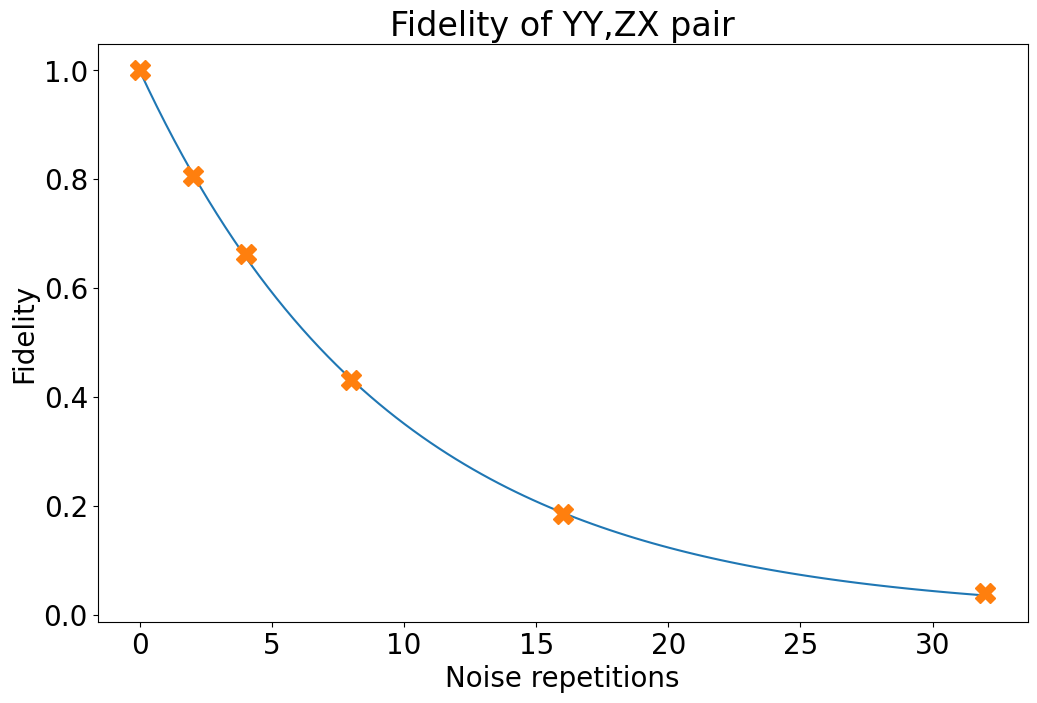

In [72]:
xrange = np.linspace(0,np.max(depths),100)
plt.figure(figsize=(12, 7.5))
plt.plot(xrange,[expfit(x,*popt) for x in xrange])
plt.plot(depths,results, "X", markersize=15)
plt.title("Fidelity of "+pauli.to_label()+","+conjugate(pauli).to_label()+ " pair", fontsize=24)
plt.ylabel("Fidelity", fontsize=20)
plt.xlabel("Noise repetitions", fontsize=20)
plt.tick_params(labelsize=20)

### Full Procedure
The full procedure is divided into distinct stages for circuit generation, execution, and expectation value extraction. This segmentation is made to utilize a feature in Qiskit that allows an entire array of circuits to be submitted to the backend simultaneously, rather than feeding them one by one. This approach improves efficiency by reducing the total usage time of real quantum hardware, as the backend can process multiple circuits more efficently. Additionally, it minimizes queuing time, as the circuits are executed in a single batch rather than requiring multiple submissions. Further details on this feature can be found on the official IBM website.

Because of the conjugation with the layer, many pauli bases only appear in pairs, which thus requires pair breaking measurements. To perform these, the paulis that require pair breaking need to be recorded.

In [73]:
def weight(pauli):
    return len([p for p in pauli if not p==Pauli("I")])

#return True if Paulis differ by "I"s only
def disjoint(pauli1, pauli2):
    return all([p1==p2 or (p1 == Pauli("I") or p2 == Pauli("I")) for p1,p2 in zip(pauli1, pauli2)])

#return True if pauli requires a degeracy lifting measurement. This is the case, when both the pauli, and the pair, which has to be a different pauli, appear the list of model terms.
def requires_single(pauli):
    pair = conjugate(pauli)
    return (pauli in model_terms and pair in model_terms) and pauli != pair

#find disjoint operators that can be measured simultaneously to find six bases
pairs = set([frozenset([p,conjugate(p)]) for p in model_terms if requires_single(p)])
single_bases = []
for p1,p2 in pairs:
    for i,pauli in enumerate(single_bases):
        if disjoint(pauli, p1) and disjoint(pauli, p2):
            single_bases[i] = nophase(pauli.compose(p2)) 
            break
    else:
        single_bases.append(p2)

print("bases for singles: ",single_bases)
print([(pauli.to_label(), conjugate(pauli).to_label()) for pauli in single_bases])

bases for singles:  [Pauli('IX'), Pauli('IY'), Pauli('ZZ'), Pauli('YY'), Pauli('YX'), Pauli('YI')]
[('IX', 'XX'), ('IY', 'XY'), ('ZZ', 'ZI'), ('YY', 'ZX'), ('YX', 'ZY'), ('YI', 'YZ')]


#### Generate circuits
The first cell generates the required number of samples at varying depths using the nine pauli bases and the single degeneracy-lifting measurements in the six bases computed earlier.

In [74]:
circuits = [] #Where the circuits are being stored
depths = [2,4,8,16]
samples = 32
single_samples = 250
total = len(bases)*samples*len(depths)+len(single_bases)*single_samples #This is just for the "progress bar" below

j=0 #This is also for the progress bar
for basis, d in product(bases, depths): #For every combination of basis and depths
    for i in range(samples): #Create 'samples' samples
        circ = instance(basis, basis, d)
        circ.metadata["type"] = "double" #Remember if it was a double (n is even) or single
        circuits.append(circ)

        j+=1 							#Progress bar
        print(j,"/",total, end='\r') 	#Progress bar

for basis, s in product(single_bases, range(single_samples)):
    #Start in the pair basis, measure in main basis to obtain correct fidelity. 
    #Reason: In the model the error acts after the ideal gate, so the gate will change basis to main basis on which the error is then applied
    circ = instance(conjugate(basis),basis,1) 
    circ.metadata["type"] = "single" #Remember if it was a double (n is even) or single
    circuits.append(circ)

    j+=1 							#Progress bar
    print(j,"/",total, end='\r') 	#Progress bar

#### Get results
Once the circuits are generated, they can be submitted as an array in no particular order directly to the processor

In [75]:
results = backend.run(circuits, shots=1024, noise_model = noise_model).result().get_counts()

#### Analysis
The cells below show the anlysis of the data obtained from a run of the procedure.

During circuit generation, all circuits were collected into a single array for execution. The cell below separates them again into their two categories: main circuits (double) and pair-breaking circuits (single).

In [76]:
#Sort into single and double measurements
for res,circ in zip(results, circuits):
    circ.metadata["counts"] = res

singles = []
doubles = []
for circ in circuits:
    datum = circ.metadata
    type = datum["type"]
    datum.pop("type")
    if type == "single":
        singles.append(datum)
    elif type == "double":
        doubles.append(datum)

All measurements can be used to obtain values for multiple paulis. For example the basis XY yields values for the paulis XY, IY and XI.

The `sim_meas` method below determines how many model terms can be measured simultaneously given a basis.

In [77]:
#Shows whether two pauli operators can be measured simultaneously
def simultaneous(pauli1, pauli2):
    return all([p1==p2 or p2 == Pauli("I") for p1,p2 in zip(pauli1, pauli2)])

#Gives a list of all terms in the model that can be measured simultaneously with pauli
def sim_meas(pauli):
    return [term for term in model_terms if simultaneous(pauli, term)]

#Gives a list of all terms, in the sparse model or not, that can be measured simultaneously
#This is used to overdeteremine the model, but since it grows as 2^n, this method can always be
#replaced with sim_meas
def all_sim_meas(pauli):
    return [Pauli("".join(p)) for p in product(*zip(pauli.to_label(), "I"*num_qubits))]
#all_sim_meas = sim_meas

The expectation values for all paulis are collected. For every `doubles` circuit the simultaneous measurements are looked up. The results are then saved to those paulis.

In [78]:
#reorder by measurement basis
basis_dict = {}
#improve execution time by storing runs of all_sim_meas for each basis
sim_measurements = {}
for datum in doubles:
    #get run data
    basis = datum['prep_basis']
    depth = datum['depth']
    #find simultaneous measurements
    if not basis in sim_measurements:
        sim_measurements[basis] = all_sim_meas(basis)
    #aggregate expectation value data for each simultaneous measurement
    for pauli in sim_measurements[basis]:
        expectation = get_expectation(pauli, **datum)
        #set up dictionary
        if not pauli in basis_dict:
            basis_dict[pauli] = {"expectation":[0 for d in depths], "total":[0 for d in depths]}
        #add expectation value to result at depth
        basis_dict[pauli]["expectation"][depths.index(depth)] += expectation
        basis_dict[pauli]["total"][depths.index(depth)] += 1

Use curve-fits to determine all fidelity pairs and extract SPAM coefficients from the intercepts of the fits.

In [79]:
expfit = lambda x,a,b : a*np.exp(x*-b)
#for each of the simultaneous measurements
for key in basis_dict.keys(): #key is here the same as pauli in block above
    for i,d in enumerate(depths):
        #divide by total
        basis_dict[key]["expectation"][i] /= basis_dict[key]["total"][i]
    #try finding exponential fit, default to ideal if no fit found
    try:
        popt, pcov = curve_fit(expfit, depths, basis_dict[key]["expectation"], p0=[.9,.01])
    except:
        popt = 1,0

    #store fidelity and SPAM coefficients
    basis_dict[key]["fidelity"] = expfit(1,1,popt[1]) # could put this line in the if below because singles don't use this ever
    basis_dict[key]["SPAM"] = popt[0] #find out more about this

    #record whether measurement appears as a pair or as a single fidelity
    if key != conjugate(key): #Same as is_single
        basis_dict[key]["type"] = "pair" #denote if the value is "sqrt(f^dagger*f)"
    else:
        basis_dict[key]["type"] = "single" #of if it is just f

Aggregate the results of the single measurements to lift the degeneracy in the model

In [80]:
singles_dict = {} #store results of single measurements
sim_measurements = {}
for datum in singles:
    meas_basis = datum['meas_basis']
    prep_basis = datum['prep_basis']
    #find terms that can be measured simultaneously
    if not meas_basis in sim_measurements:
        sim_measurements[meas_basis] = []
        for term in model_terms:
            if simultaneous(meas_basis, term) and simultaneous(prep_basis, conjugate(term)) and requires_single(term):
                sim_measurements[meas_basis].append(term)
    #aggregate data together
    for meas in sim_measurements[meas_basis]:
        if meas not in singles_dict:
            singles_dict[meas] = 0
        expectation = get_expectation(meas, **datum)
        #the measurement basis SPAM coefficients are closer because the readout noise, combined
        #with the noise from the last layer, is greater than the state preparation noise
        fidelity = np.min([1.0,np.abs(expectation)/basis_dict[meas]["SPAM"]])
        singles_dict[meas] += fidelity/single_samples

#add singles data to basis_dict
for key in singles_dict.keys():
    basis_dict[key]['fidelity'] = singles_dict[key]
    basis_dict[key]['type'] = "single"

## Results

In [81]:
#graph a subset of the measured expectation values and plot fits
def graph(*paulis):
    colcy = cycle(["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:cyan", "tab:brown", "tab:pink", "tab:gray", "tab:olive"])
    for p in paulis:
        c = next(colcy)
        data = basis_dict[p]['expectation']
        popt, pcov = curve_fit(expfit, depths, data, p0=[.9,.01])
        xrange = np.linspace(0,np.max(depths))
        plt.plot(xrange, [expfit(x, *popt) for x in xrange], color=c)
        plt.plot(depths, data, color = c, marker="o", linestyle = 'None')
    plt.title("Expectation vs Depth")
    plt.xlabel("Depth")
    plt.ylabel("Fidelity")

#display the measured fidelities plotted against the ideal fidelitites
def display(*paulis):
	plt.figure(figsize=(15, 5))
	ax = np.arange(len(paulis))
	fidelities = []
	fidelities_calculated = []
	for p in paulis:
		fid = basis_dict[p]['fidelity']
		if(basis_dict[p]['type'] == 'pair'):
			pair = conjugate(p)
			fid = fid**2/basis_dict.get(pair,{'fidelity': 1})['fidelity']
		fidelities.append(fid)
		fidelities_calculated.append(real_errors[p])
	plt.bar(ax+.2, [(1-f) for f in fidelities], .4,color='tab:blue', label="Measured")
	plt.bar(ax-.2, [(1-f) for f in fidelities_calculated],.4, color='tab:green', label="Ideal")
	#plt.xticks(ax, paulis, rotation=45)
	plt.xticks(ax, ["".join(reversed(pauli.to_label())) for pauli in paulis], rotation=45)
	plt.title("Measured vs Actual Fidelitites", fontsize=24)
	plt.xlabel("Term", fontsize=20)
	plt.ylabel("1-f", fontsize=20)
	plt.tick_params(labelsize=16)
	plt.legend(fontsize=20,loc="upper left")

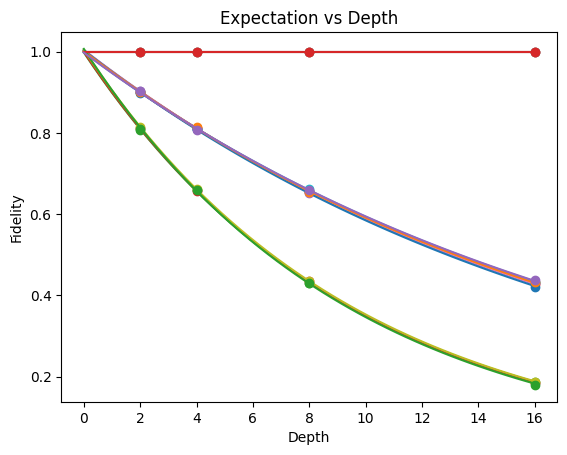

In [82]:
graph(*model_terms)


e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\matplotlib\transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\matplotlib\transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


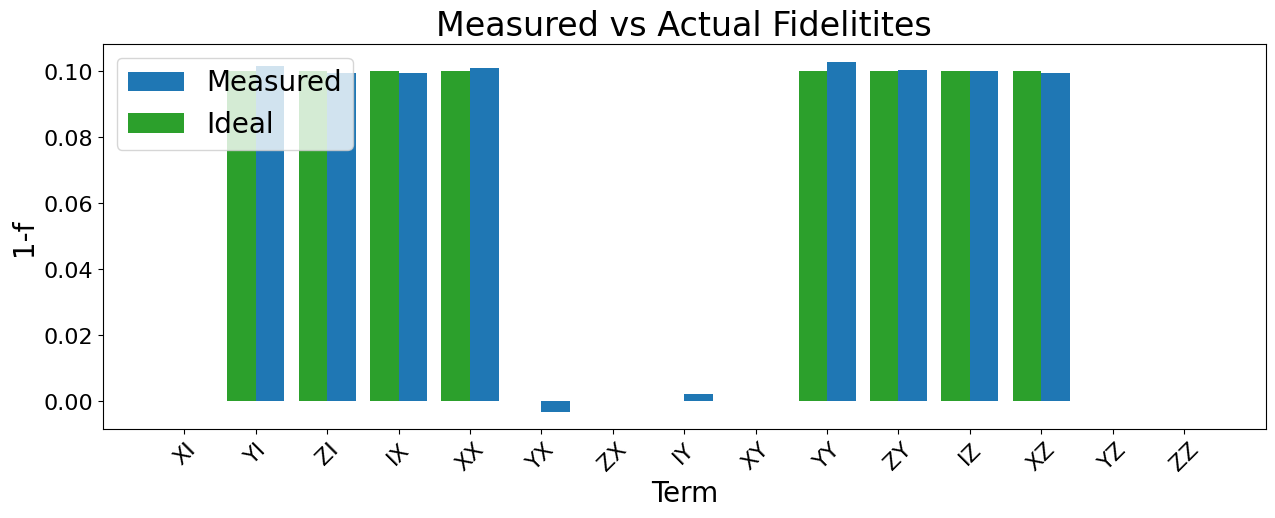

In [83]:
display(*model_terms)

### Learn model terms
The lists $F_1$ and $F_2$ can be constructed in the following way: First, $F_1$ is chosen to be $F$, the set of sparse model terms. The list $F_2$ is chosen to be the same as $F_1$ if the single fidelity is known, and changes to the conjugate fidelity if a pair is known.

In [84]:
f1 = []
f2 = []
fidelities = []
for key in model_terms:
    f1.append(key)
    fidelities.append(basis_dict[key]['fidelity'])
    if basis_dict[key]["type"] == "pair":
        pair = conjugate(key)
        f2.append(pair)
    else: #here is single
        f2.append(key)

Construct the matrices $M_1$ and $M_2$

In [85]:
sprod = lambda a,b: int(a.anticommutes(b))# This is the anticommutator
M1 = [[sprod(a,b) for a in model_terms] for b in f1]
M2 = [[sprod(a,b) for a in model_terms] for b in f2]

In [86]:
print(M1)

[[0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1], [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0], [1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0], [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1], [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1], [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0], [1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0], [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1], [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1], [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1], [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]]


The matrix should be full rank

In [87]:
np.linalg.matrix_rank(np.add(M1,M2)) == len(model_terms)

np.True_

Since the vector of fidelitites $\vec f$ is either $f_a$ or $\sqrt{f_a'f_a}$, the equation for calculating the model terms is
$$
(M_1+M_2)\vec \lambda+\log(\vec f) = 0
$$
The equation for calculating the model terms using single fidelities is the same as the original:
$$
M\vec \lambda + \frac{1}{2}\log(\vec f) = 0
$$

In [88]:
coeffs,rnorm = nnls(np.add(M1,M2), -np.log([f.real for f in fidelities]))
real_coeffs, real_rnorm = nnls(M1, -.5*np.log([real_errors[term].real for term in f1]))

One thing to note is that the graph in van den Berg et Al. doesn't plot the actual coefficients vs ideal coefficients, but simply the goodness of fit using nnls. We can see here that the ideal coefficients and actual coefficients are not quite the same. The computed coefficients are always bigger and the difference grows with increasing error.

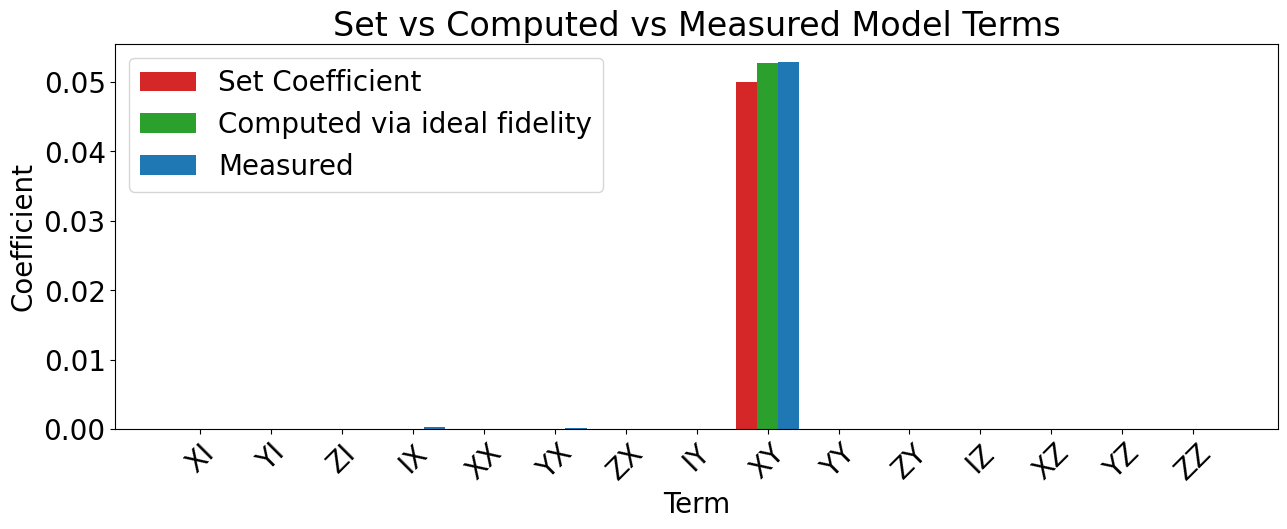

In [89]:
ideal_coeffients = [{term: error_state[term] for term in error_state}.get(term, 0) for term in model_terms] 
ax = np.arange(len(model_terms))
plt.figure(figsize=(15, 5))
plt.bar(ax-.3, ideal_coeffients, .3, color='tab:red', label="Set Coefficient")
plt.bar(ax, real_coeffs, .3, color='tab:green', label="Computed via ideal fidelity")
plt.bar(ax+.3, coeffs, .3, color='tab:blue', label="Measured")

#plt.xticks(ax, model_terms, rotation=45)
plt.xticks(ax, ["".join(reversed(pauli.to_label())) for pauli in model_terms], rotation=45)
plt.title("Set vs Computed vs Measured Model Terms", fontsize=24)
plt.xlabel("Term", fontsize=20)
plt.ylabel("Coefficient", fontsize=20)
plt.legend(fontsize=20)
plt.tick_params(labelsize=20)

e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


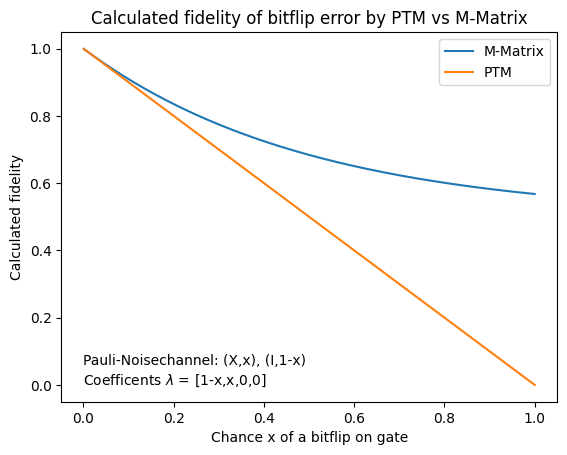

In [90]:
M1_test = [[sprod(a,b) for a in [Pauli('I'), Pauli('X'), Pauli('Y'), Pauli('Z')]] for b in [Pauli('I'), Pauli('X'), Pauli('Y'), Pauli('Z')]]
M2_test = M1_test
singlequbit_errorops = [Pauli('X')] 
save2 = []
for i in range(1000):
	singlequbit_errorprobs = [1-i/1000]
	singlequbit_error_template = [(op, p) for op,p in zip(singlequbit_errorops, singlequbit_errorprobs)]+[(Pauli("I"), 1-sum(singlequbit_errorprobs))]
	extra = pauli_error(singlequbit_error_template)
	real_errors2 = {}
	transfer_matrix = PTM(extra.to_quantumchannel()).data
	for i,pauli in enumerate(pauli_basis(1)):
		real_errors2[pauli] = transfer_matrix[i][i]
	save2.append(sum([real_errors2[key] for key in real_errors2])/4)
    
save = []
for i in range(1000):
	ideal_coeffients2 = [i/1000,1-i/1000,0,0]
	ideal_fidelities2 = np.exp(-np.matmul(np.add(M1_test,M2_test),ideal_coeffients2))
	#print(ideal_coeffients2)
	#print(ideal_fidelities2)
	save.append(sum(ideal_fidelities2)/4)
xaxis = [1-i/1000 for i in range(1000)]
plt.plot(xaxis, save, label="M-Matrix")
plt.plot(xaxis, save2, label="PTM")

plt.text(0, 0.06, "Pauli-Noisechannel: (X,x), (I,1-x)")
plt.text(0, 0, "Coefficents $\lambda$ = [1-x,x,0,0]")
plt.title("Calculated fidelity of bitflip error by PTM vs M-Matrix")
plt.xlabel("Chance x of a bitflip on gate")
plt.ylabel("Calculated fidelity")
plt.legend()

e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


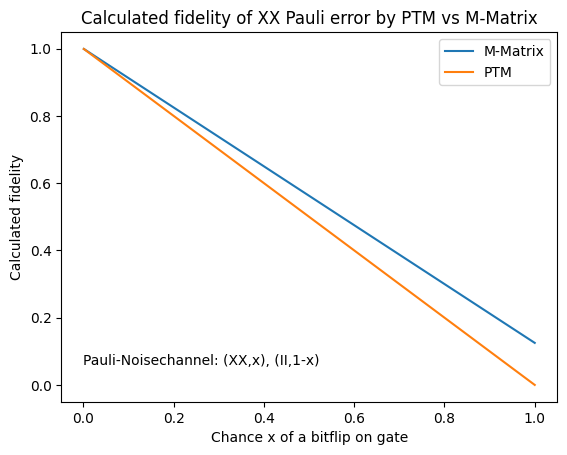

In [122]:
twoqubit_error = [Pauli('XX')] 
save2 = []
for i in range(1000):
	twoqubit_errorprobs = [1-i/1000]
	twoqubit_error_template = [(op, p) for op,p in zip(twoqubit_errorops, twoqubit_errorprobs)]+[(Pauli("II"), 1-sum(twoqubit_errorprobs))]
	extra = pauli_error(twoqubit_error_template)
	real_errors2 = {}
	transfer_matrix = PTM(extra.to_quantumchannel()).data
	for i,pauli in enumerate(pauli_basis(2)):
		real_errors2[pauli] = transfer_matrix[i][i]
	save2.append(sum([real_errors2[key] for key in real_errors2])/16)
    
save = []
for i in range(1000):
	twoqubit_errorprobs = [1-i/1000]
	twoqubit_error_template = [(op, p) for op,p in zip(twoqubit_errorops, twoqubit_errorprobs)]+[(Pauli("II"), 1-sum(twoqubit_errorprobs))]
	ideal_coeffients2 = [{term: value for (term, value) in twoqubit_error_template}.get(term, 0) for term in pauli_basis(2)][1:]
	ideal_fidelities2 = np.add([1 for term in pauli_basis(2)][1:],(-np.matmul(np.add(M1,M2),ideal_coeffients2)))
	save.append((1+sum(ideal_fidelities2))/16)
xaxis = [1-i/1000 for i in range(1000)]
plt.plot(xaxis, save, label="M-Matrix")
plt.plot(xaxis, save2, label="PTM")

plt.text(0, 0.06, "Pauli-Noisechannel: (XX,x), (II,1-x)")
#plt.text(0, 0, "Coefficents $\lambda$ = [1-x,x,0,0]")
plt.title("Calculated fidelity of XX Pauli error by PTM vs M-Matrix")
plt.xlabel("Chance x of a bitflip on gate")
plt.ylabel("Calculated fidelity")
plt.legend()

In [107]:
a = [1,2,3]
b = [5]
b+a

[5, 1, 2, 3]

In [93]:
print([{term: value for (term, value) in twoqubit_error_template}.get(term, 0) for term in pauli_basis(2)])

[0.95, 0, 0, 0, 0, 0, 0, 0, 0, 0.05, 0, 0, 0, 0, 0, 0]
